In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table

# astropy to import fits files
from astropy.io import fits

In [32]:
file_data = fits.open("/home/groneck/Exoplanet_Project/spi_phy905/CFHT/812176i.fits")

string_data = file_data[0].header["date"] # gets the data from the fits file
string_data

'2012-05-09T14:37:08'

In [33]:
from astropy.time import Time
def date_string_to_tuple(date_string):
    date = date_string.split('T')[0]
    time = date_string.split('T')[1]
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])
    day = int(date.split('-')[2])
    hour = int(time.split(':')[0])
    minute = int(time.split(':')[1])
    second = int(float(time.split(':')[2]))
    # Convert to BJD using astropy Time
    # Convert to BJD_TDB
    time_tuple = (year, month, day, hour, minute, second)
    return time_tuple

time_tuple = date_string_to_tuple(file_data[0].header["date"])
time_tuple  # prints the time tuple

(2012, 5, 9, 14, 37, 8)

(640.0, 670.0)

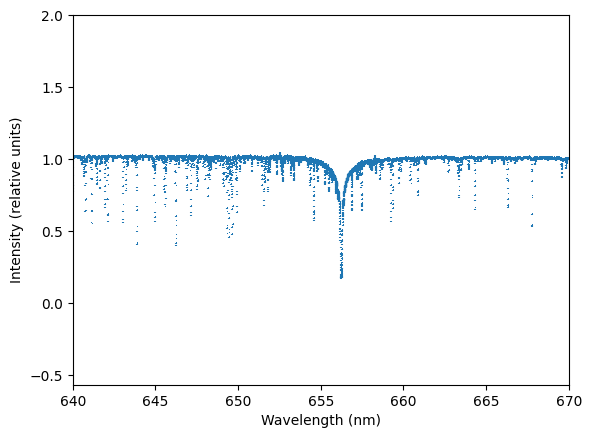

In [34]:
# df = pd.DataFrame(data[0].data[0:2])
col_1 = file_data[0].data[0]
col_2 = file_data[0].data[1]
col_3 = file_data[0].data[2]
df = pd.DataFrame({'Wavelength': col_1, 'Intensity': col_2, 'Error': col_3})
df.head()
# ensure data is sorted by wavelength
# plt.plot(df['Wavelength'], df['Intensity'], ',')
plt.errorbar(df['Wavelength'], df['Intensity'], yerr=df['Error'], fmt=',')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (relative units)')
plt.xlim(640, 670)


In [35]:
wavelengths = np.array(df['Wavelength'])
intensities = np.array(df['Intensity'])
errors = np.array(df['Error'])
# new_df = pd.DataFrame({'Wavelength': wavelengths, 'Intensity': intensities, 'Error': errors})
# new_df
new_df = pd.DataFrame({'Wavelength': wavelengths, 'Intensity': intensities, 'Error': errors})

In [36]:
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt

# plt.style.use("dark_background")

from astropy.modeling.models import Linear1D
from astropy import constants
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fc6ec298890>

In [37]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Lorentz1D, Linear1D, Voigt1D, Moffat1D
from astropy.modeling.fitting import LevMarLSQFitter, LinearLSQFitter

(640.0, 670.0)

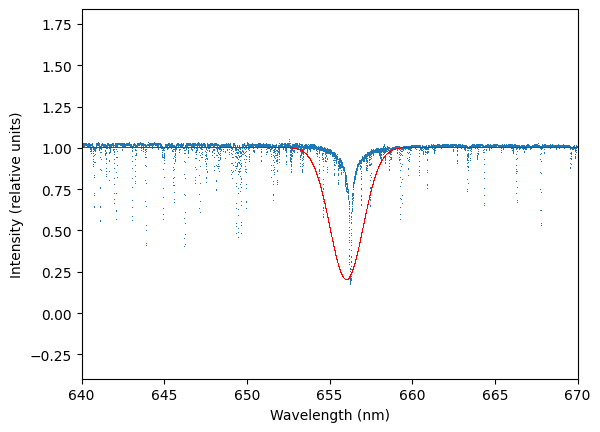

In [38]:
absorption_model_guess = Linear1D(slope=0, intercept=1) + Gaussian1D(
    amplitude=-0.8, mean=656, stddev=1
)
# absorption_model_guess = Linear1D(slope=0, intercept=1) + Lorentz1D(
#     amplitude=-0.8, x_0=656, fwhm=1
# )
plt.plot(df['Wavelength'], df['Intensity'], ',')
plt.plot(
    df['Wavelength'],
    absorption_model_guess(df['Wavelength']),
    ',',
    color='red'
)
plt.ylabel('Intensity (relative units)')
plt.xlabel('Wavelength (nm)')
plt.xlim(640, 670)

Text(0, 0.5, 'Intensity (relative units)')

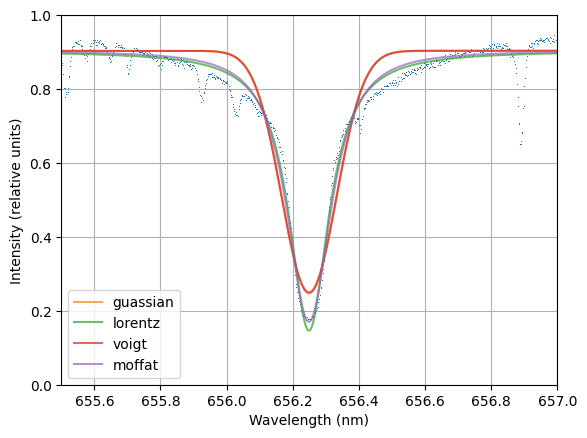

In [62]:
fitted_absorption_guess_guassian = Linear1D(slope=0, intercept=1) + Gaussian1D(
    amplitude=-0.8, mean=656, stddev=1
)

absorption_model_guess_lorentz = Linear1D(slope=0, intercept=1) + Lorentz1D(
    amplitude=-0.8, x_0=656, fwhm=1
)

absorption_model_guess_voigt = Linear1D(slope=0, intercept=1) + Voigt1D(
    amplitude_L=-0.8, x_0=656, fwhm_L=1, fwhm_G=1
)

absorption_model_guess_moffat = Linear1D(slope=0, intercept=1) + Moffat1D(
    amplitude=-0.8, x_0=656, gamma=1, alpha=1
)

models = [
    ('guassian', fitted_absorption_guess_guassian),
    ('lorentz', absorption_model_guess_lorentz),
    ('voigt', absorption_model_guess_voigt),
    ('moffat', absorption_model_guess_moffat)
]


fitter = LevMarLSQFitter()
def fit_model(model, wavelengths, intensities):
    fitted_model = fitter(model, wavelengths, intensities)
    return fitted_model

plt.plot(wavelengths, intensities, ',')

for model_set in models:
    name, model = model_set
    fitted_absorption_model = fit_model(model, wavelengths, intensities)
    # sort wavelengths for plotting
    sorted_indices = np.argsort(wavelengths)
    plt.plot(wavelengths[sorted_indices], fitted_absorption_model(wavelengths[sorted_indices]), '-', label=name, alpha=0.7)


plt.xlim(655.5, 657)
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (relative units)')

(654.2, 658.2)

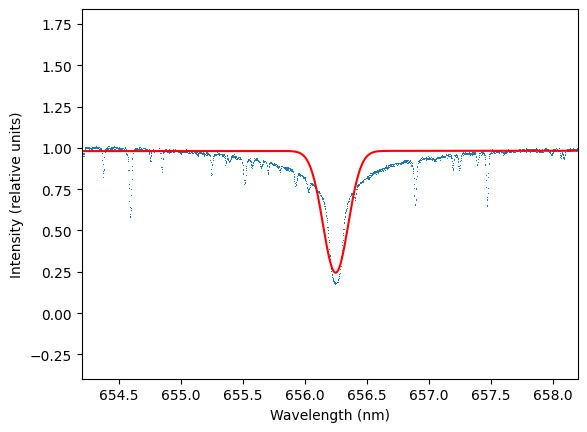

In [40]:
lmfitter = LevMarLSQFitter()
selection = (wavelengths > 640) & (wavelengths < 670)
fitted_absorption_model = lmfitter(
    model=absorption_model_guess, x=wavelengths[selection], y=intensities[selection], weights=1 / errors[selection]
)

plt.plot(wavelengths, intensities, ',')
# sort wavelengths for plotting
sorted_indices = np.argsort(wavelengths)
plt.plot(wavelengths[sorted_indices], fitted_absorption_model(wavelengths[sorted_indices]), color='red')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (relative units)')
plt.xlim(654.2, 658.2)


(640.0, 670.0)

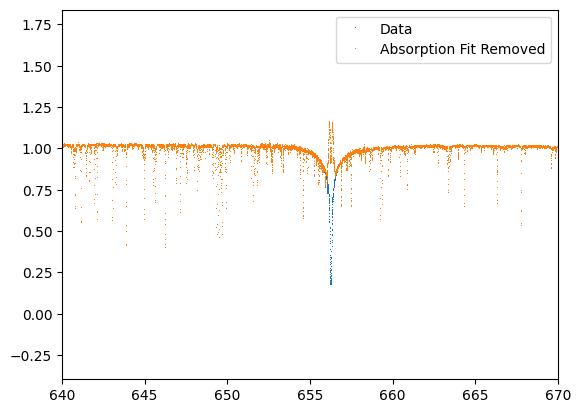

In [41]:
continuum_fit, absorption_fit = fitted_absorption_model

plt.plot(wavelengths, df['Intensity'], ',', label='Data')
plt.plot(wavelengths, df['Intensity'] - absorption_fit(wavelengths), ',', label='Absorption Fit Removed')
plt.legend()
plt.xlim(640, 670)


In [42]:
#documentation example:
# EQW = (
#     -absorption_fit(wavelengths.value[selection]).sum() / continuum_fit.intercept * u.nm
# )
# EQW

EQW = (
    -absorption_fit(wavelengths[selection]).sum() / continuum_fit.intercept
)
EQW

np.float64(156.59096222038391)

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import Linear1D, Gaussian1D
from astropy.io import fits
import os

def calculate_eqw(data, plot=False, line_center=656.28, window=(640, 670)):
    wavelengths = np.asarray(data['Wavelength'], dtype=float) * u.nm
    intensities = np.asarray(data['Intensity'], dtype=float)
    errors      = np.asarray(data['Error'], dtype=float)

    # 1) Filter non-finites up front
    finite = np.isfinite(wavelengths.value) & np.isfinite(intensities) & np.isfinite(errors)
    wavelengths, intensities, errors = wavelengths[finite], intensities[finite], errors[finite]

    # 2) Focus on a wavelength window around the line
    sel = (wavelengths > window[0] * u.nm) & (wavelengths < window[1] * u.nm)
    if not np.any(sel):
        return np.nan  # nothing to fit

    w, f = wavelengths[sel], intensities[sel]

    # 3) Build a reasonable initial model guess
    #    Estimate continuum ~ median of edges in the window
    left  = (w.value > window[0]) & (w.value < line_center - 5)
    right = (w.value > line_center + 5) & (w.value < window[1])
    if np.any(left) and np.any(right):
        cont_level = 0.5 * (np.median(f[left]) + np.median(f[right]))
    else:
        cont_level = np.median(f)

    # Rough line depth guess: difference between continuum and min in core
    core = np.abs(w.value - line_center) < 1.0
    depth_guess = cont_level - np.min(f[core]) if np.any(core) else 0.1 * cont_level
    amp_guess = -abs(depth_guess)  # absorption → negative amplitude

    # Rough width guess (in same units as w)
    std_guess = 0.8

    absorption_model_guess = Linear1D(slope=0.0, intercept=cont_level) + Gaussian1D(
        amplitude=amp_guess, mean=line_center, stddev=std_guess
    )

    # 4) Fit
    lmfitter = LevMarLSQFitter()
    fitted_absorption_model = lmfitter(
        model=absorption_model_guess,
        x=w.value, y=f
        )

    # Extract submodels
    # For a sum model m = m0 + m1, you can index by order:
    continuum_fit, absorption_fit = fitted_absorption_model

    if plot:
        plt.figure()
        plt.plot(w, f, ',', label='Data')
        plt.plot(w, fitted_absorption_model(w.value), '-', label='Fit')
        plt.plot(w, f - absorption_fit(w.value), ',', label='Absorption Fit Removed')
        plt.legend()
        plt.xlim(*window)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity')
        plt.tight_layout()


    Fc = continuum_fit(w.value)
    F  = fitted_absorption_model(w.value)

    good = Fc > 0
    Fc = Fc[good]
    F  = F[good]
    wl = w.value[good]

    integrand = 1.0 - F / Fc
    eqw_value = np.trapezoid(integrand, wl) * u.nm
    return eqw_value

# --- Batch over files ---
base_file_path = "/home/groneck/Exoplanet_Project/spi_phy905/CFHT/"
file_names = sorted(os.listdir(base_file_path))

eqw_rows = []
used_names = []
time_tuples = []

for file_name in file_names:
    if not file_name.endswith('.fits'):
        continue
    file_path = os.path.join(base_file_path, file_name)
    with fits.open(file_path) as hdul:
        col_1 = hdul[0].data[0]
        col_2 = hdul[0].data[1]
        col_3 = hdul[0].data[2]
    df = pd.DataFrame({'Wavelength': col_1, 'Intensity': col_2, 'Error': col_3})

    eqw_value = calculate_eqw(df, plot=False)


    time_tuple = date_string_to_tuple(hdul[0].header["date"])
    time_tuples.append(time_tuple)

    eqw_rows.append(eqw_value)
    used_names.append(file_name)

eqw_data_frame = pd.DataFrame({'data_set': used_names, 'EQW_Value': eqw_rows, 'Time(Y,M,D,H,M,S)': time_tuples})
print(eqw_data_frame)


         data_set               EQW_Value          Time(Y,M,D,H,M,S)
0   1849608i.fits  0.44664005786852995 nm  (2015, 11, 29, 6, 44, 41)
1   1849608p.fits  0.44759576220798214 nm  (2015, 11, 29, 6, 54, 10)
2   1849609i.fits   0.4471566858092657 nm  (2015, 11, 29, 6, 44, 42)
3   1849610i.fits   0.4470004150288195 nm   (2015, 11, 29, 6, 45, 9)
4   1849611i.fits   0.4480303618473406 nm  (2015, 11, 29, 6, 44, 46)
5   2558520p.fits   0.4471182066315634 nm    (2020, 12, 5, 7, 2, 18)
6   2558524p.fits  0.45440672124926634 nm     (2020, 12, 5, 7, 4, 7)
7   2558528p.fits  0.45666723898887085 nm    (2020, 12, 5, 7, 5, 48)
8   2558532p.fits   0.4551030838825705 nm    (2020, 12, 5, 7, 7, 32)
9   2558536p.fits    0.515536693107612 nm    (2020, 12, 5, 7, 9, 18)
10  2558540p.fits   0.4590829233162205 nm   (2020, 12, 5, 7, 10, 53)
11  2558544p.fits   0.4618493891029128 nm   (2020, 12, 5, 7, 12, 36)
12  2558548p.fits   1.0981775734577692 nm   (2020, 12, 5, 7, 14, 16)
13   812176i.fits   0.443193485744

In [ ]:
#save files to csv
eqw_data_frame.to_csv('cfht_eqw_results.csv', index=False)